## ICP SLAM

In [2]:
# List the imports here
import numpy as np
from scipy.optimize import fsolve
import open3d as o3d
import time
# from PIL import Image
from IPython.display import display, Image
# from open3d import JVisualizer
import random
import os
# import cv2
import matplotlib.pyplot as plt
import sys
import copy

import json
import math
#hi

### SECTION 1: Non-Linear least squares optimization for Gaussian function

#### 1.1 Levenberg Marquardt

Implement the Levenberg Marquardt algorithm from scratch using numpy to solve for the parameters of a gaussian distribution.

A Gaussian distribution parametrized by $a,m,s$ is given by:

$$ y(x;a,m,s)=a \exp \left(\frac{-(x-m)^{2}}{2 s^{2}}\right) \tag{1}$$

##### Problem to solve

> Given a set of observations $y_{obs}$ and $x_{obs}$ we want to find the optimum parameters $a,m,s$ which best fit our observations given an initial estimate.

* Experiment with the number of iterations.
* Experiment with the learning rate.
* Experiment with the tolerance.

Display your results using matplotlib by plotting graphs for 
* The cost function value ($\|r\|^2$) vs the number of iterations
* The Ground Truth data values and the predicted data values.

Experiment with the hyperparameters and compile your observations in a table. Clearly mention your hyperparameters with justification.

You can refer to [Shubodh's notes](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02) on the same to get a better grasp of the concept before implementing it.

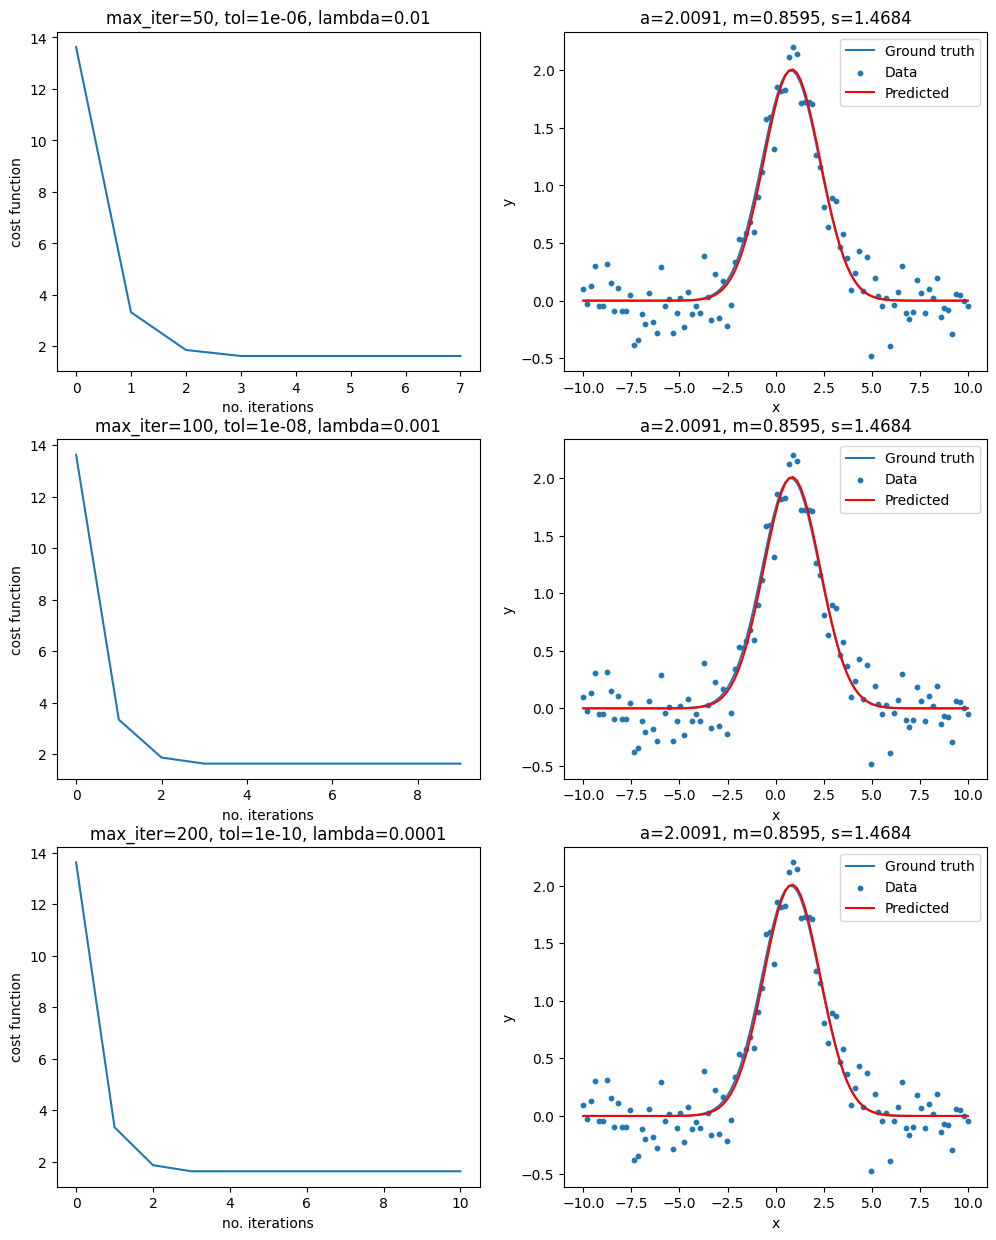

In [3]:
##############################################################################
# TODO: Do tasks described in 1.1 (a)
##############################################################################

# Replace "pass" statement with your code
import numpy as np
import matplotlib.pyplot as plt


def gaussian(x, a, m, s):
    return a * np.exp(-np.square((x - m)) / (2 * s ** 2))

def residual(par, x, y):
    return y - gaussian(x, *par)

def jacobian(par, x, y):
    J = np.zeros((len(x), len(par)))
    J[:, 0] = np.exp(-((x - par[1]) / par[2]) ** 2 / 2)
    J[:, 1] = par[0] * (x - par[1]) / par[2] ** 2 * np.exp(-((x - par[1]) / par[2]) ** 2 / 2)
    J[:, 2] = par[0] * (x - par[1]) ** 2 / par[2] ** 3 * np.exp(-((x - par[1]) / par[2]) ** 2 / 2)
    return J

def levenberg_marquardt(par_init, x, y, max_iter=100, tol=1e-5, l=0.01):
    p = par_init.copy()
    r = residual(p, x, y)
    F = 0.5 * np.dot(r, r)
    F_list = [F]

    for i in range(max_iter):
        J = jacobian(p, x, y)
        g = np.dot(J.T, r)
        if np.linalg.norm(g) < tol:
            break
        H = np.dot(J.T, J) + l * np.eye(len(p))
        dp = np.linalg.solve(H, g)
        p = p + dp
        r = residual(p, x, y)
        F_new = 0.5 * np.sum(r ** 2)
        F_list.append(F_new)
        if F_new < F:
            l = l * 0.8
            F = F_new
        else:
            l = l * 2


    return p, F_list
np.random.seed(42)
x = np.linspace(-10, 10, 100)
y_true = gaussian(x, a=2, m=0.8, s=1.5)
y = y_true + 0.2 * np.random.randn(len(x))
p0 = np.array([1.0, 0.0, 1.0])

hyperparameters = [
    {"max_iter": 50, "tol": 1e-6, "l": 0.01},
    {"max_iter": 100, "tol": 1e-8, "l": 0.001},
    {"max_iter": 200, "tol": 1e-10, "l": 0.0001}]

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
for i, h in enumerate(hyperparameters):
    p_opt, F_list = levenberg_marquardt(p0, x, y, **h)
    axes[i][0].plot(F_list)
    axes[i][0].set_xlabel("no. iterations")
    axes[i][0].set_ylabel("cost function")
    axes[i][0].set_title(f"max_iter={h['max_iter']}, tol={h['tol']}, lambda={h['l']}")
    axes[i][1].plot(x, y_true, label="Ground truth")
    axes[i][1].scatter(x, y, label="Data", s=10)
    axes[i][1].plot(x, gaussian(x, *p_opt), label="Predicted", c="r")
    axes[i][1].set_xlabel("x")
    axes[i][1].set_ylabel("y")
    axes[i][1].legend()
    axes[i][1].set_title(f"a={round(p_opt[0], 4)}, m={round(p_opt[1], 4)}, s={round(p_opt[2], 4)}")

plt.show()





##############################################################################
# END OF YOUR CODE
##############################################################################

### SECTION 2: ICP

#### 2.1 Perform Procrustes alignmenton two point clouds with (given) known correspondances. 

Let X be your point cloud observed from the initial pose P1. You then transform it to a new pose P2. Now you wish to apply ICP to recover transformation between (X & P1) and (X & P2). 

Use toothless.ply point cloud and perform the alignment between the two point clouds using procrustes alignment. Your task is to write a function that takes two point clouds as input wherein the corresponding points between the two point clouds are located at the same index and returns the transformation matrix between them. Compute the alignment error after aligning the two point clouds.

**Use *root mean squared error (RSME)* as the alignment error metric.**

Make sure your code is modular as we will use this function in the next sub-part.

In [4]:
##############################################################################
# TODO: Do tasks described in 2.1
##############################################################################

# Replace "pass" statement with your code

#obtaining two point clouds by rotating and translating the one mentioned in the .ply file

def getTransformation(pcd1, pcd2):
    #applying Procrustes alignment

    points1 = np.asarray(pcd1.points)
    points2 = np.asarray(pcd2.points)
    
    #step 1: calculating centroids
    centroid1 = np.mean(points1, axis=0)
    centroid2 = np.mean(points2, axis=0)

    point1_normalized = points1-centroid1
    point2_normalized = points2-centroid2

    #step 2: calculating the cross covariance matrix
    W = point1_normalized.T @ point2_normalized


    #step 3: calculating the rotation matrix
    U, S, Vt = np.linalg.svd(W)
    rotation_matrix = np.dot(Vt.T, U.T)
    t = centroid2.T - np.dot(rotation_matrix, centroid1.T)

    #step 4: transformation matrix
    
    t1 = t[0]
    t = [t[0], 0, 0]
    
    T = np.zeros((4, 4))
    T[0:3, 0:3] = rotation_matrix
    T[0:3, 3] = t
    T[3, 3] = 1

    return T



##############################################################################
# END OF YOUR CODE
##############################################################################

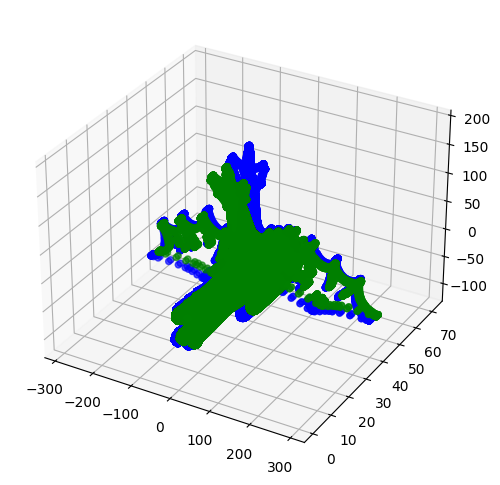

In [5]:
ply_point_cloud = "./data/toothless.ply"


pcd = o3d.io.read_point_cloud(ply_point_cloud)
pcd1 = copy.deepcopy(pcd)


rotate_by = 3.5
angle = np.radians(rotate_by)
cosa = np.cos(angle)
sina = np.sin(angle)
rotation_matrix = np.vstack(([1, 0, 0], [0, cosa, -sina], [0, sina, cosa]))
pcd.rotate(rotation_matrix)
translation_vector = [6.25, 0, 0]
pcd.translate(translation_vector)
pcd2 = copy.deepcopy(pcd)


p = np.asarray(pcd1.points)
q = np.asarray(pcd2.points)
plt.figure(figsize=(6, 6))
ax = plt.axes(projection="3d")
ax.scatter3D(p[:, 0], p[:, 1], p[:, 2], color="blue")
ax.scatter3D(q[:, 0], q[:, 1], q[:, 2], color="green")
plt.show()

In [6]:
transformation = getTransformation(pcd1, pcd2)
print(transformation)
pcd_t = copy.deepcopy(pcd1)
pcd_t1 = o3d.geometry.PointCloud.transform(pcd_t, transformation)


p = np.asarray(pcd2.points)
q = np.asarray(pcd_t1.points)

squared_errors = np.sum((p - q)**2, axis=1)
mse = np.mean(squared_errors)
rmse = math.sqrt(mse)
print(rmse)

[[ 1.00000000e+00  6.58474064e-18 -2.86004606e-18  6.25000000e+00]
 [-5.48714741e-18  9.98134798e-01 -6.10485395e-02  0.00000000e+00]
 [-2.64250841e-19  6.10485395e-02  9.98134798e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
2.8583618968493263


#### 2.2 Implement ICP algorithm with unknown correspondances.

Your task is to write a function that implements ICP and takes two point clouds as input wherein the correspondances are unknown. Visualize the pointclouds and plot their individual coordinate frames as you perform ICP over them. Compute the alignment error in each iteration.

##### Function for the algorithm

In [7]:
##############################################################################
# TODO: Do tasks described in 2.2
##############################################################################

# TAKE CARE TO SEND IN TRANSPOSES i.e. shape = (n, 3)
def findCorrespondances(p_true, p_estimate):
    '''Returns correspondances for each estimated point to the nearest true point'''

    correspondance = []
    for i in range(p_estimate.shape[0]):
        mindist = sys.maxsize
        at_idx = -1
        p2 = p_estimate[i]
        for j in range(p_true.shape[0]):
            p1 = p_true[j]
            dist = np.linalg.norm(p1 - p2)
            if dist < mindist:
                mindist = dist
                at_idx = j
        correspondance.append((i, at_idx))
    return correspondance

In [8]:
def showCorrespondances(p_true, p_estimate, C, vis):
    '''Displays corresponadances calculated as lines in the visualisation'''
    
    num_points = len(p_estimate)
    points = []
    for pt in p_estimate:
        points.append(pt)
    for pt in p_true:
        points.append(pt)
        
    lines = []
    for c in C:
        lines.append([c[0], num_points+c[1]])

    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),
    )
    line_set.colors = o3d.utility.Vector3dVector(colors)
    vis.add_geometry(line_set)

In [9]:
def centroid(p):
    '''Finds the centroid for a point cloud'''

    return np.array([p.mean(axis=0)]).T

def findRT(p_true, p_estimate, C):
    '''Finds the optimal rotation and transformation matrix'''
    
    c_true = centroid(p_true)
    c_estimate = centroid(p_estimate)
    
    weight = np.zeros((3,3))
    for i, j in C:
        p1 = p_true[j].T.reshape((3,1)) - c_true
        p2 = p_estimate[i].T.reshape((3,1)) - c_estimate
        weight += p1.dot(p2.T)
    weight /= p_true.shape[0]

    U, S, V = np.linalg.svd(weight)
    mtx = np.eye(3)
    mtx[2][2] = np.linalg.det(U) * np.linalg.det(V.T)
    R = U.dot(mtx.dot(V))
    Rt = R.T
    T = c_true - Rt.dot(c_estimate)

    return R, T

In [10]:
def icp(p_true, p_estimate):
    '''Iteratively runs the ICP algorithm
        Returns all the data computed while executing the algorithm'''
    
    correspondances = [] # [[(i, j)]]
    R_values = []
    T_values = []
    points = []
    points.append(p_estimate)

    prev_corresp = findCorrespondances(p_true, p_estimate) #[(i, j)] i belongs to range(len(p_true)) j is range(len(p_estimate))
    
    iters = 0
    while True:
        iters += 1
        correspondances.append(prev_corresp)
        R, T = findRT(p_true, p_estimate, prev_corresp)
        R_values.append(R)
        T_values.append(T)

        p_estimate_new = np.zeros(p_estimate.shape)
        for i in range(len(p_estimate)):
            pt = np.reshape(p_estimate[i], (3, 1))
            pt = R.dot(pt) + T
            for j in range(len(pt)):
                p_estimate_new[i][j] = pt[j]
        p_estimate = p_estimate_new
        points.append(p_estimate)

        diff = p_estimate - p_true
        err = np.sum(np.abs(diff))
        if err <= 0.001:
            break
        
        corresp = findCorrespondances(p_true, p_estimate)
        prev_corresp = corresp

    return points, correspondances, R_values, T_values, iters

##### Generating point clouds using a function

z is a function of x and y as defined below.

In [11]:
def f(x, y):
    z = x**2 - y + 2*x*y
    return z

In [12]:
n = 5
x = list(range(n))
y = list(range(n))
z = []

for i in range(n):
    z.append(f(x[i], y[i]))

true_points = np.zeros((3, n))
true_points[0] = x
true_points[1] = y
true_points[2] = z

# rotate and translate each point
angle = np.pi/6
cosa = np.cos(angle)
sina = np.sin(angle)

R = np.array([
            [1, 0, 0],
            [0, cosa, -sina],
            [0, sina, cosa]
        ])

T = np.array([[2], [3], [-1]])

estimate_points = np.zeros((3, n))
for i in range(n):
    point = np.array([[true_points[0][i]], [true_points[1][i]], [true_points[2][i]]])
    transformed = np.matmul(R, point) + T
    # transformed = point + T
    estimate_points[0][i] = transformed[0][0]
    estimate_points[1][i] = transformed[1][0]
    estimate_points[2][i] = transformed[2][0]

true_points = np.transpose(true_points)
true_cloud = o3d.geometry.PointCloud()
true_cloud.points = o3d.utility.Vector3dVector(true_points)
true_cloud.paint_uniform_color([0.2, 0.5, 0.8])

estimate_points = np.transpose(estimate_points)
estimate_cloud = o3d.geometry.PointCloud()
estimate_cloud.points = o3d.utility.Vector3dVector(estimate_points)
estimate_cloud.paint_uniform_color([0.4, 0.2, 0.2])

PointCloud with 5 points.

##### Implementing the algorithm

In [13]:
points, correspondances, R_values, T_values, num_iterations = icp(true_points, estimate_points)
print(num_iterations)

4


##### Observations

It can be observed that the final obtained value of the points and the true value are quite similar:

In [14]:
print(points[len(points)-1])
print()
print(true_points)

[[-6.55031585e-15  1.10467191e-14 -1.67088565e-14]
 [ 1.00000000e+00  1.00000000e+00  2.00000000e+00]
 [ 2.00000000e+00  2.00000000e+00  1.00000000e+01]
 [ 3.00000000e+00  3.00000000e+00  2.40000000e+01]
 [ 4.00000000e+00  4.00000000e+00  4.40000000e+01]]

[[ 0.  0.  0.]
 [ 1.  1.  2.]
 [ 2.  2. 10.]
 [ 3.  3. 24.]
 [ 4.  4. 44.]]


Running visualisations

In [17]:
n = len(points) - 1
for i in range(n):
    vis = o3d.visualization.Visualizer()
    vis.create_window()

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points[i])
    point_cloud.paint_uniform_color([0.4, 0.2, 0.2])

    vis.add_geometry(true_cloud)
    vis.add_geometry(point_cloud)
    showCorrespondances(true_points, points[i], correspondances[i], vis)
    vis.run()
    vis.capture_screen_image(f"2.2/{i}.jpg")

# final
vis = o3d.visualization.Visualizer()
vis.create_window()

point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points[n])
point_cloud.paint_uniform_color([0.4, 0.2, 0.2])

vis.add_geometry(true_cloud)
vis.add_geometry(point_cloud)
vis.run()
vis.capture_screen_image(f"2.2/{n}.jpg")


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


Results obtained by the visualisations

Iteration  1


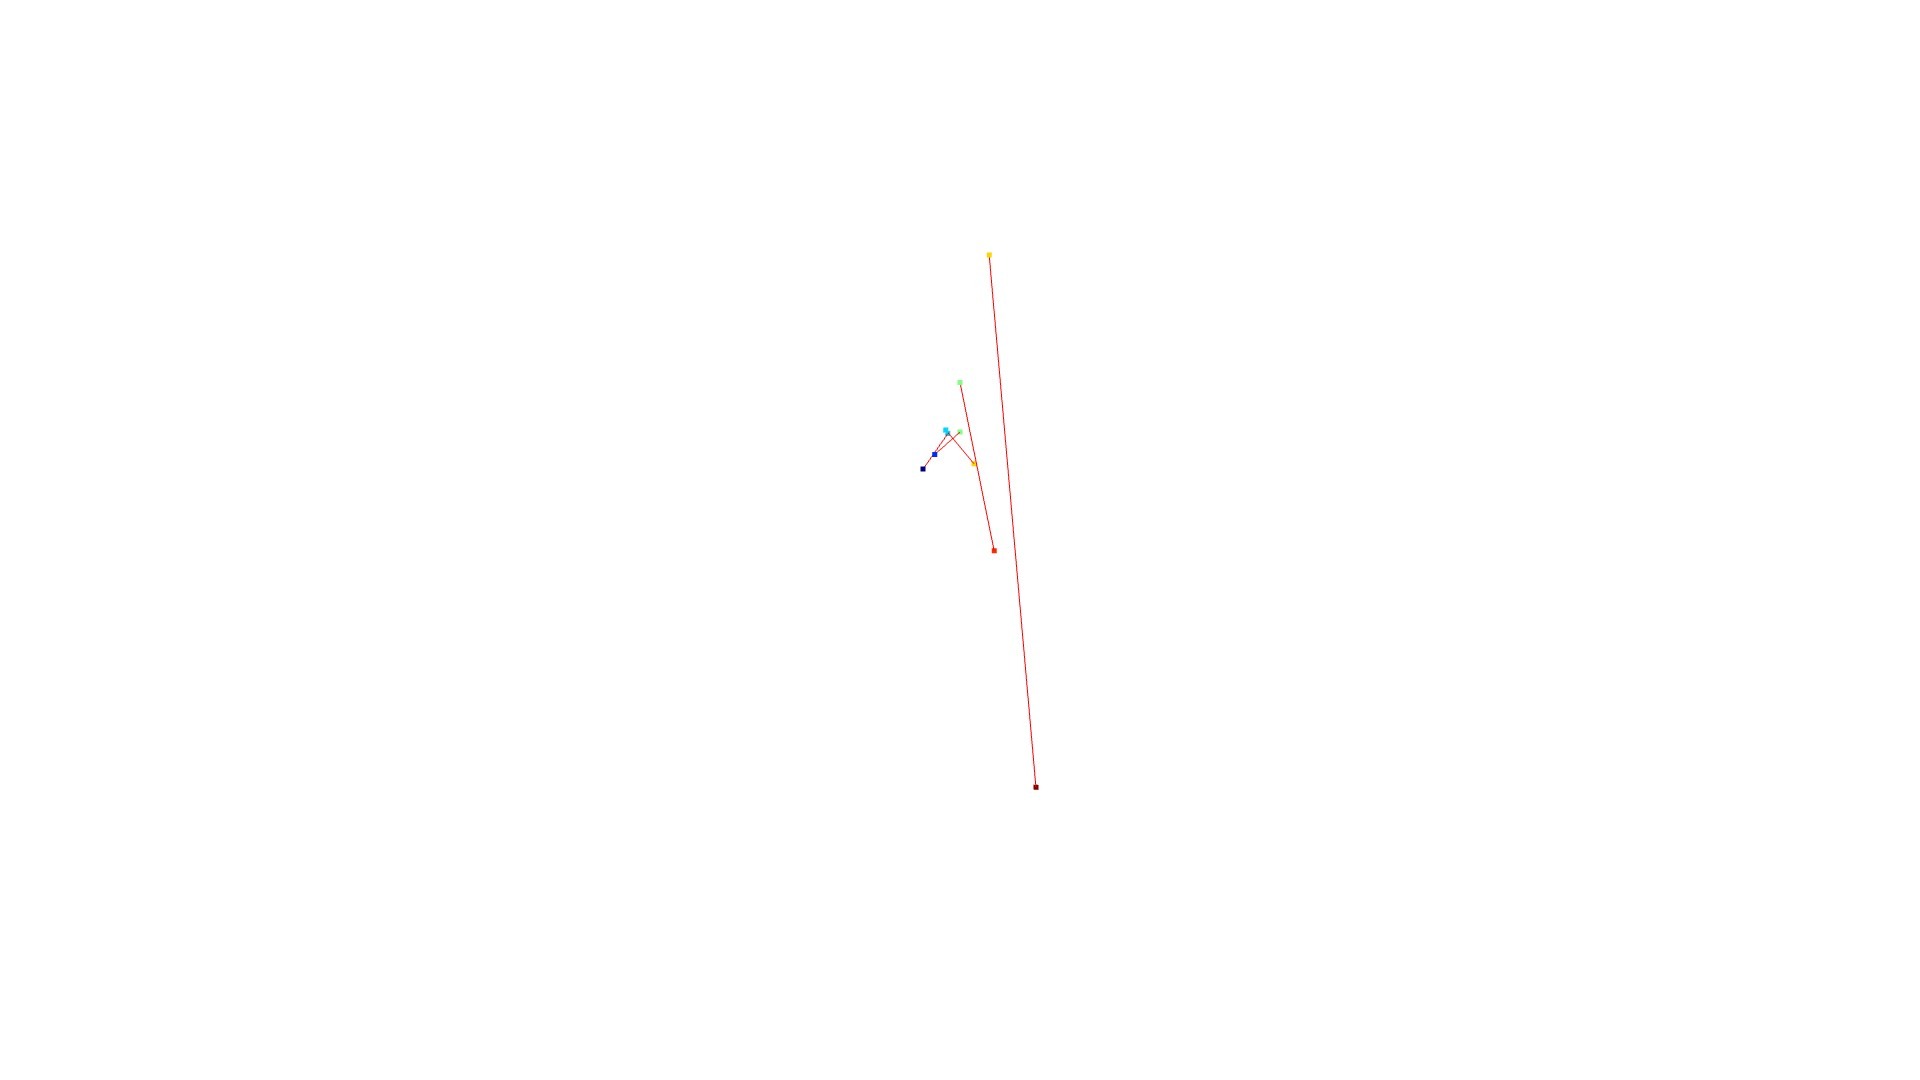

Iteration  2


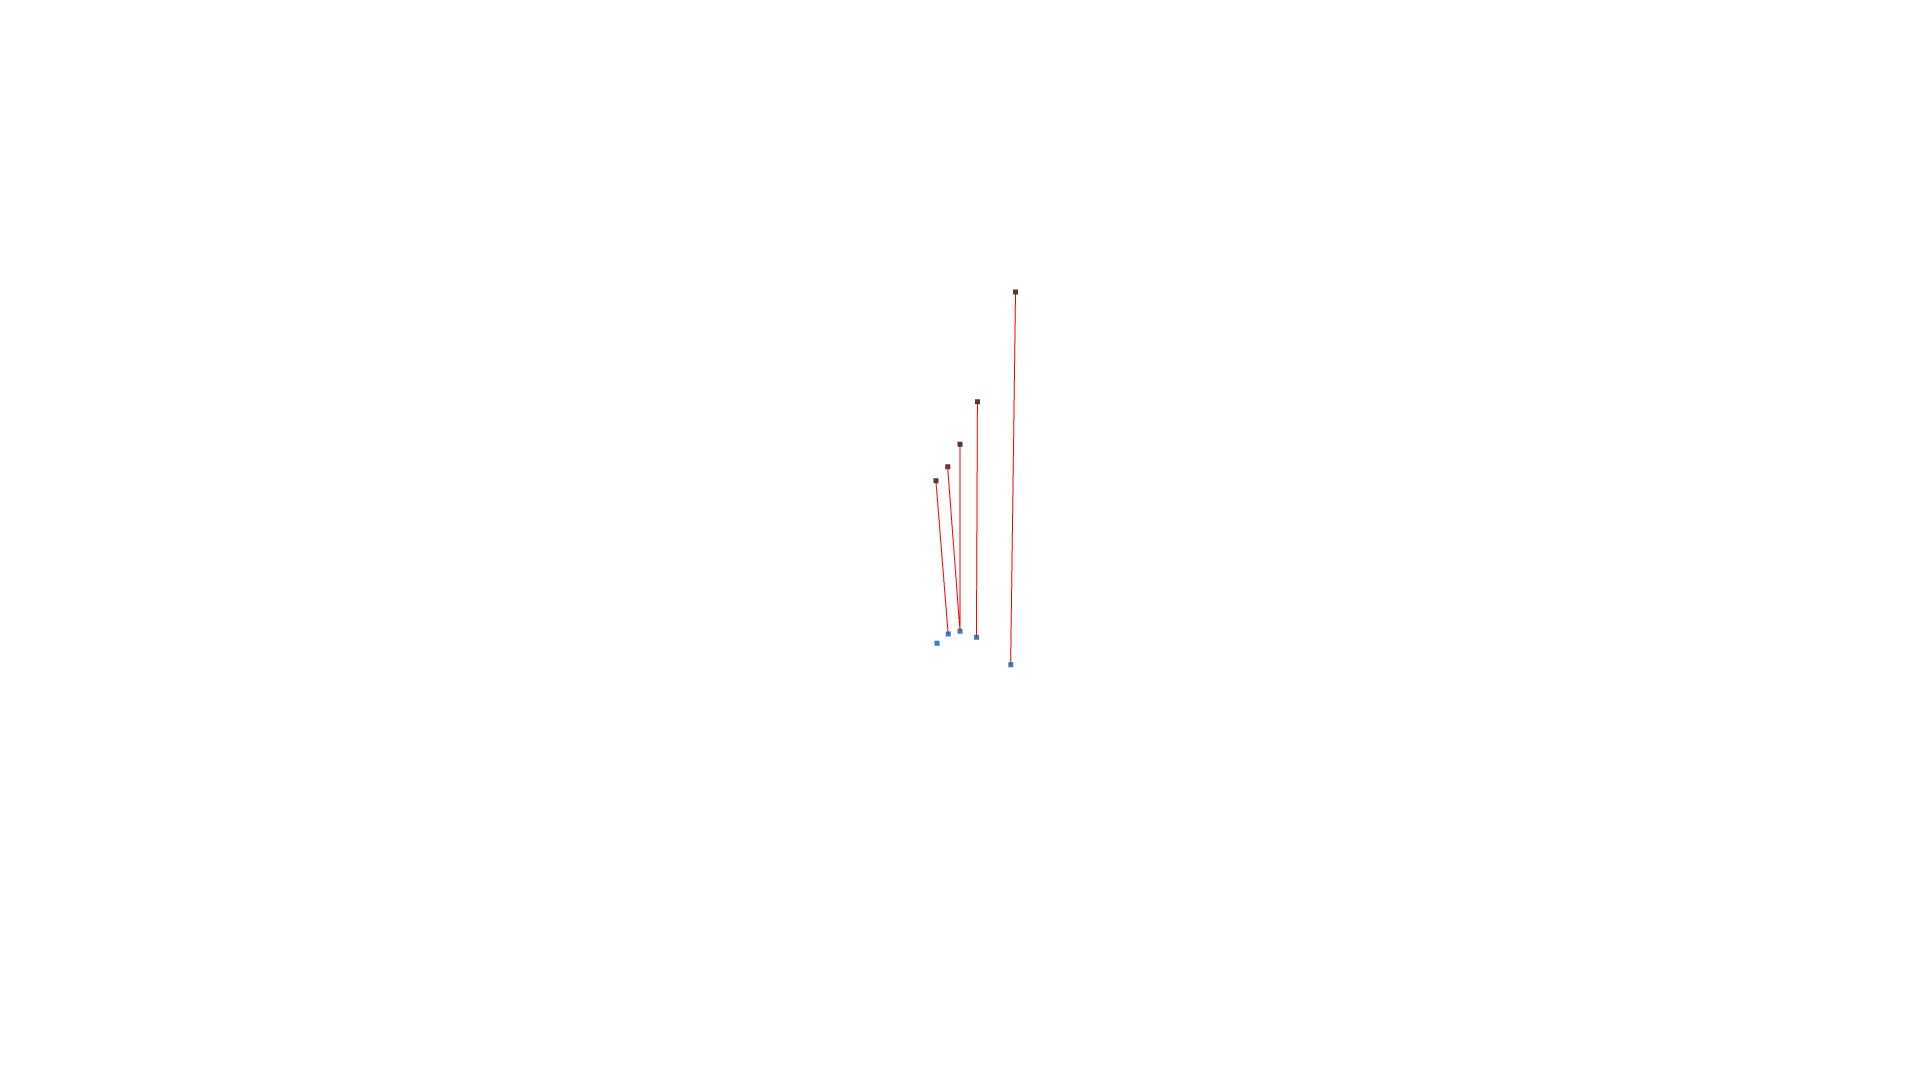

Iteration  3


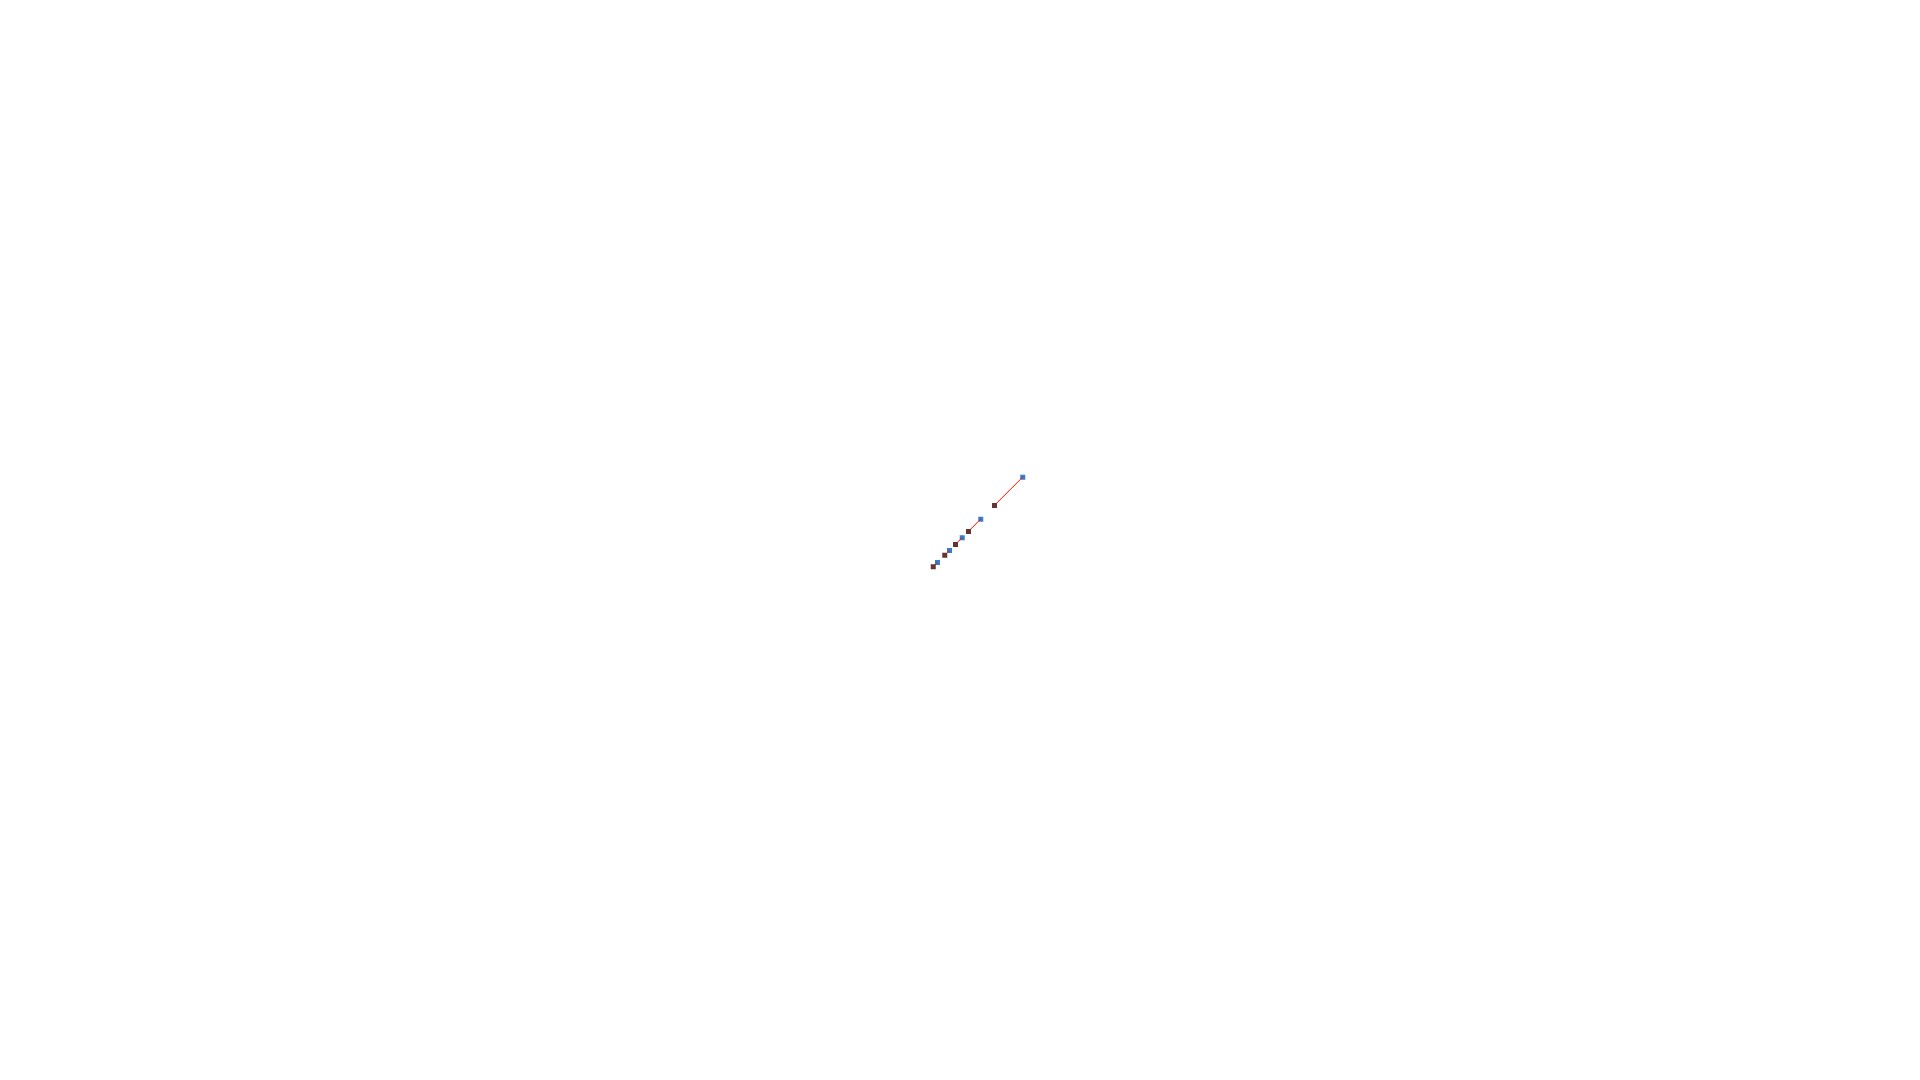

Iteration  4


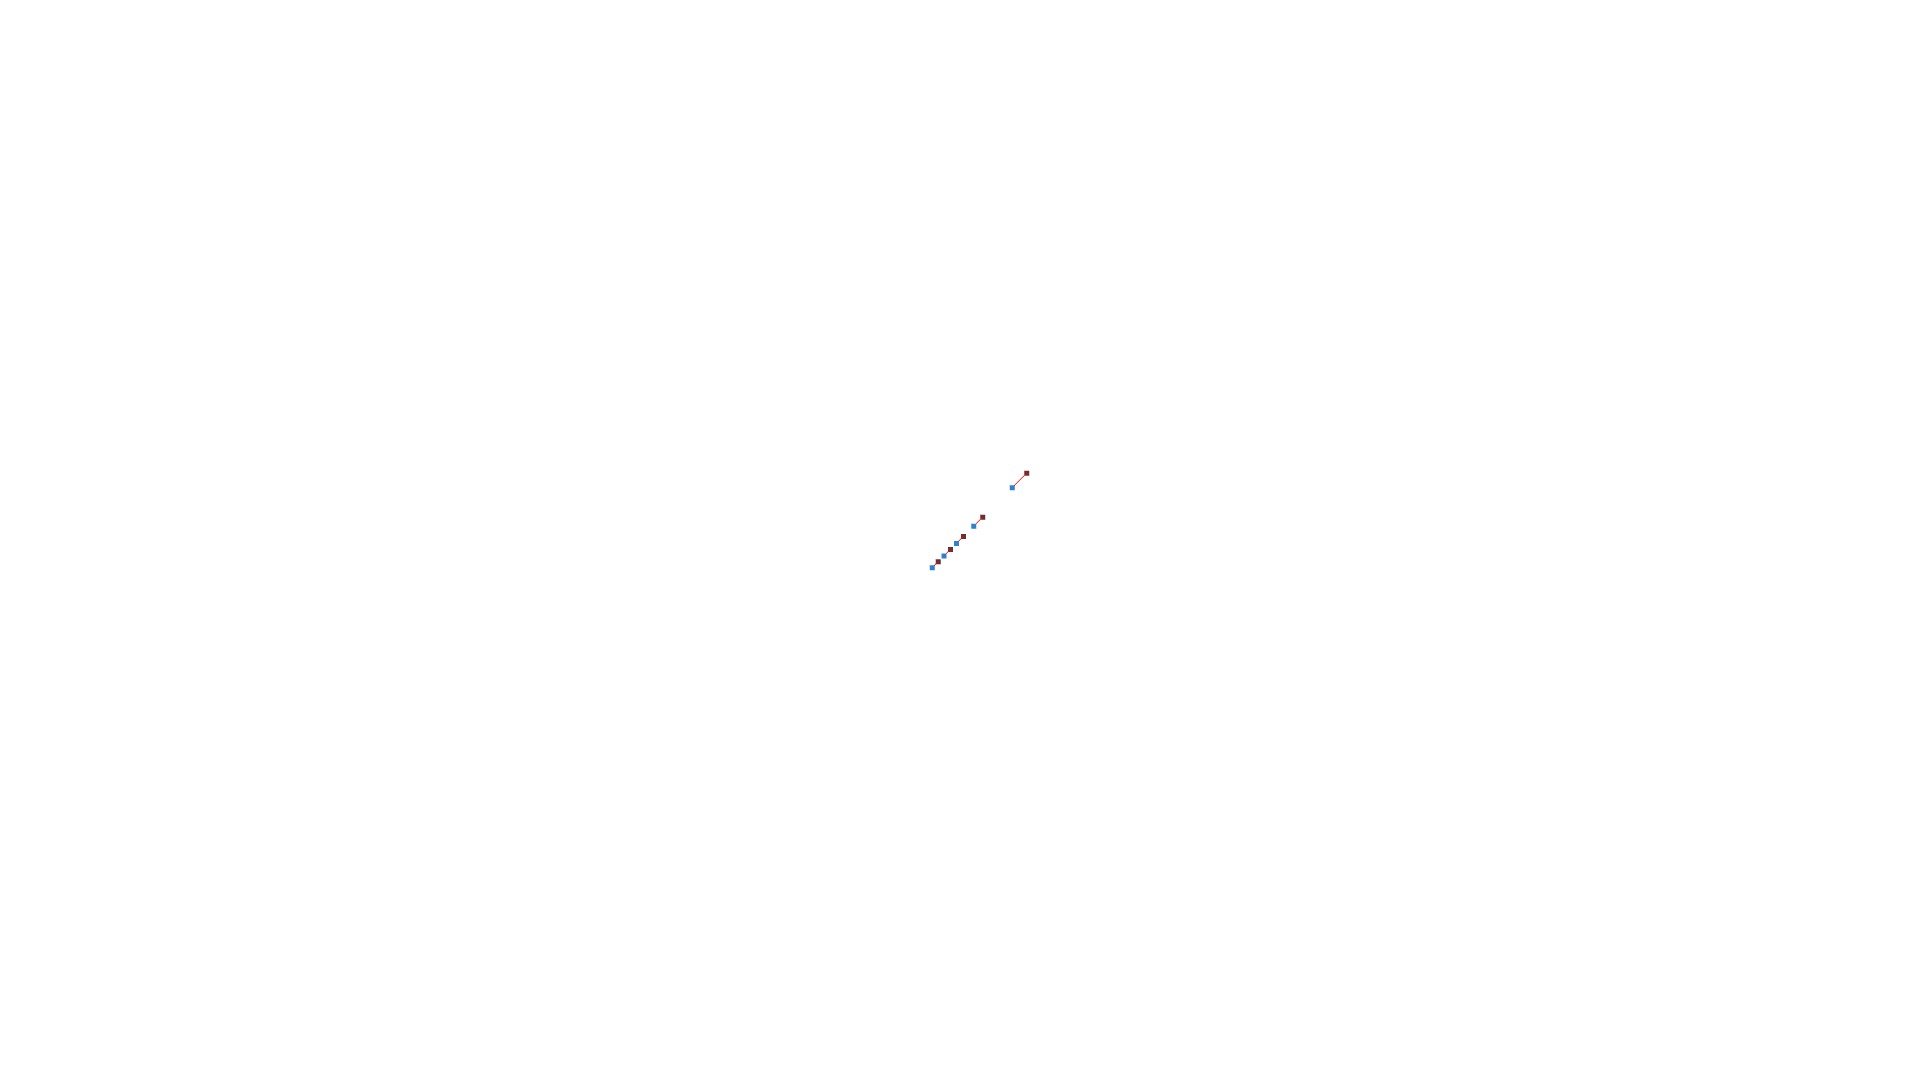

Iteration  5


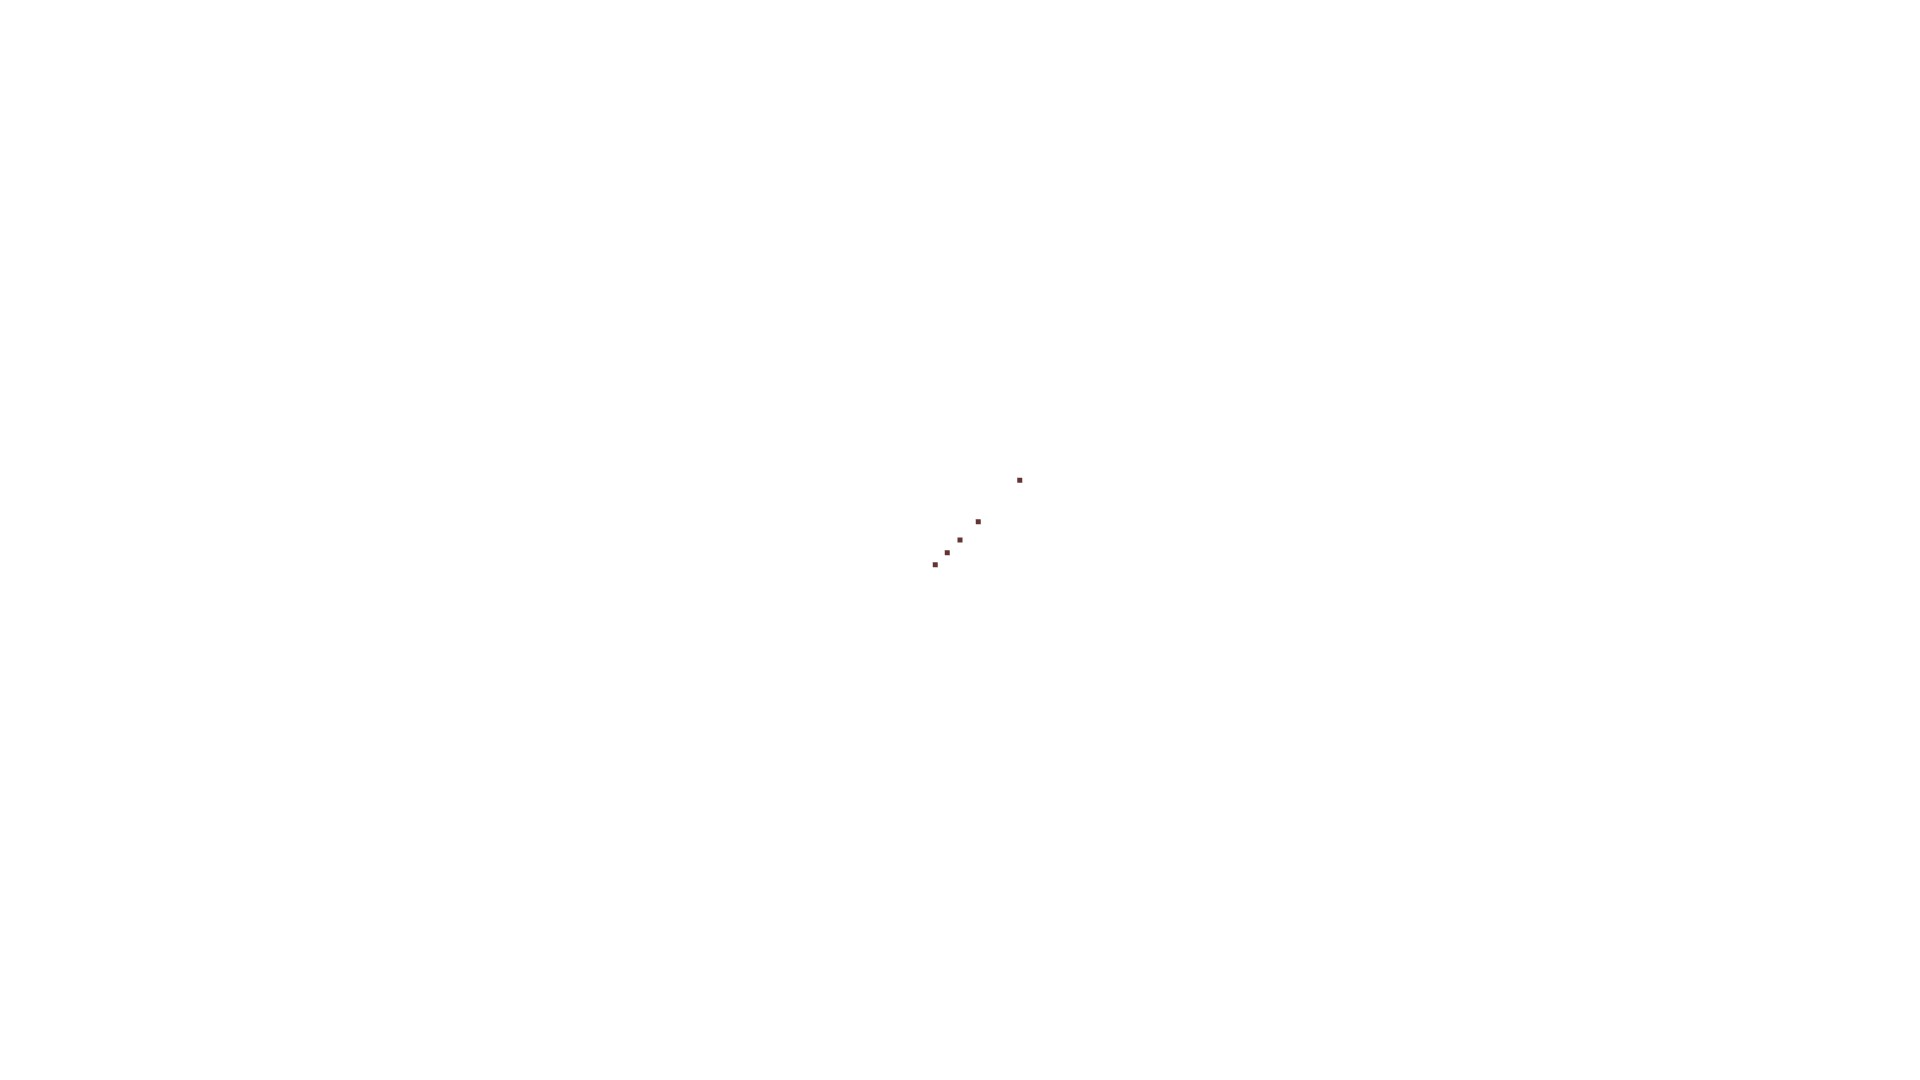

In [18]:
for i in range(n+1):
    print("Iteration ", i+1)
    img = f"2.2/{i}.jpg"
    display(Image(img))